# Investigate simulations with individual soil column per pft, for whole grid cell

Inne Vanderkelen - October 2023

## 1. Settings

In [17]:
# laod modules 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup'

case   = case_ctl
block  = 'lnd' 
stream = 'h0' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = [ "TWS",  "TOTSOILLIQ","TOTSOILICE", "SOILWATER_10CM",  "QINFL" , "QOVER", "QDRAI", "ZWT", "FH2OSFC",'EFLX_LH_TOT', 'QIRRIG_FROM_SURFACE', 'H2OSOI', "SOILLIQ","SOILICE","watsat","QROOTSINK", "QVEGE", "QVEGT","QSOIL", "TSA" ]

# discard 2004 until 2008 as spin up years
start_year, end_year = 1990, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

## 2. Load data

### Load simulations

In [4]:
ds_ctl = import_case(case_ctl, myVars=variables, timeSlice=time_slice)

In [5]:
ds_scen = import_case(case_scen, myVars=variables, timeSlice=time_slice)

In [8]:
# check if in hydrol variable list and if so, convert units
def conv_hydrol_var(ds_in, variables):

    for variable in variables: 
        da_in = ds_in[variable]

        if da_in.units == 'mm/s':
            ds_in[variable] = conv_mm_s_to_m_year(da_in)

        elif da_in.units == 'W/m^2': 
            ds_in[variable] = conv_W_per_m2_to_m_year(da_in)

        else: 
            ds_in[variable] = da_in

    return ds_in

# conversion function
def conv_mm_s_to_mm_day(da_in):

    da_out = da_in * 86400  
    # update attributes and change units
    da_out.attrs= da_in.attrs
    da_out.attrs['units'] = 'mm/day' 

    return da_out

# conversion function
def conv_W_per_m2_to_m_year(da_in):
    
    # latent heat of vaporization
    lamda = 2.501 * 10**6 #J/kg
    da_out = da_in *(1/(lamda * 1000) )  * 86400 * 365 # m/year                      
    # update attributes and change units
    da_out.attrs = da_in.attrs
    da_out.attrs['units'] = 'm/year' 

    return da_out

# conversion function
def conv_mm_s_to_m_year(da_in):

    if not da_in.attrs['units'] == 'm/year':
        da_out = da_in * 86400  * 365 * 0.001
        # update attributes and change units
        da_out.attrs= da_in.attrs
        da_out.attrs['units'] = 'm/year' 
    else: 
        da_out = da_in
        
    return da_out


In [9]:
ds_ctl = conv_hydrol_var(ds_ctl, variables)
ds_scen = conv_hydrol_var(ds_scen, variables)


In [10]:
ds_delta = ds_scen - ds_ctl 

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [11]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [12]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_CROP', 'PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [13]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 50
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)



In [14]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

## 3. Analysis & plotting

### Plotting settings

In [15]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

plotting_depth = 2 # m 8
figsize = (17,38)


### Plot absolute differences for variables

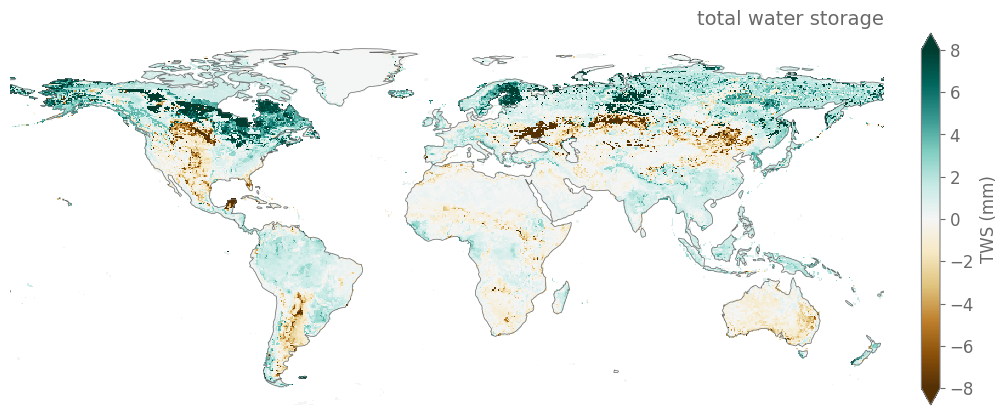

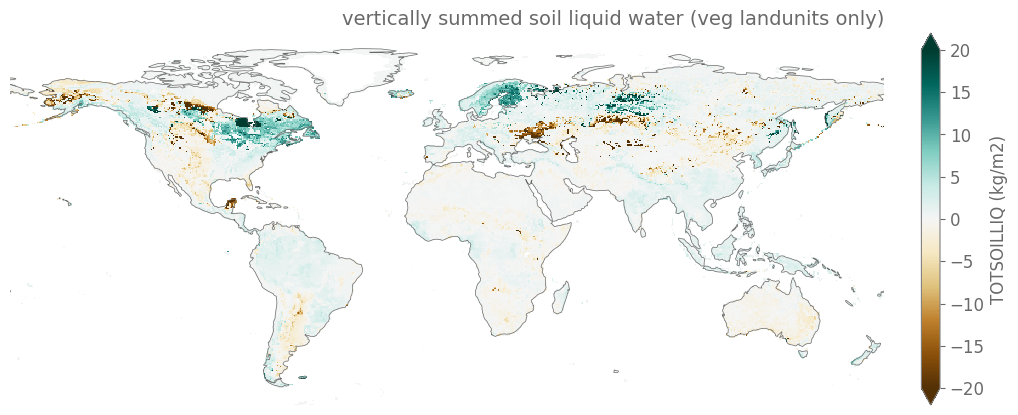

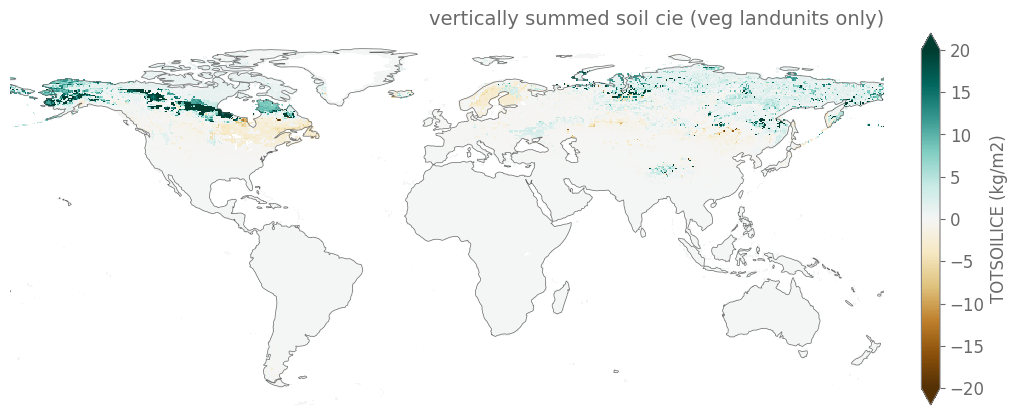

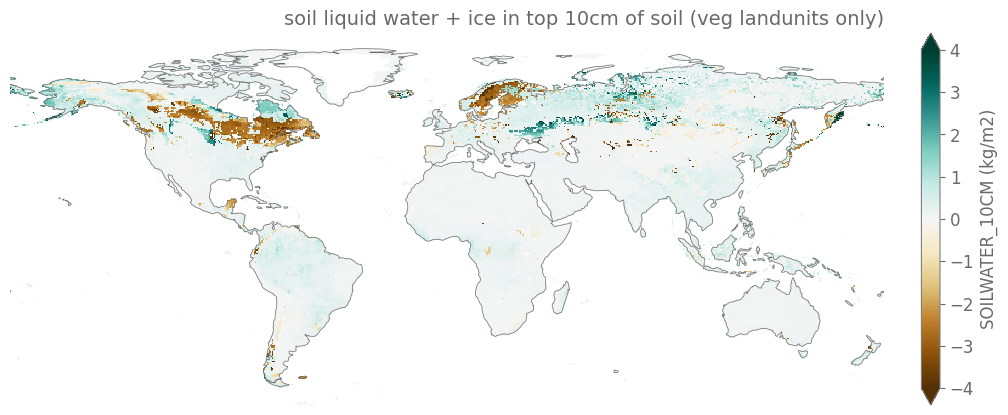

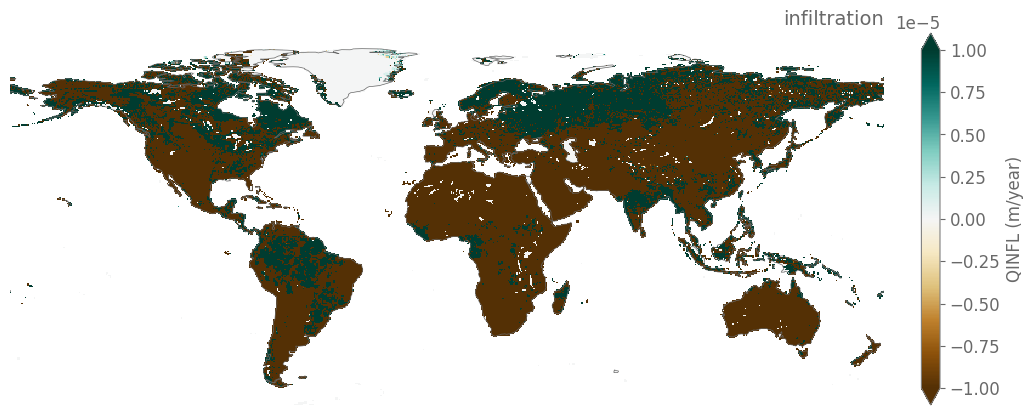

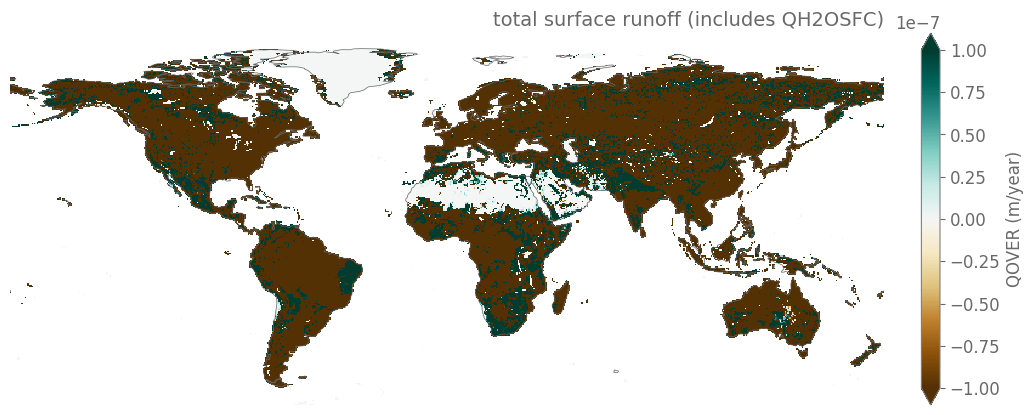

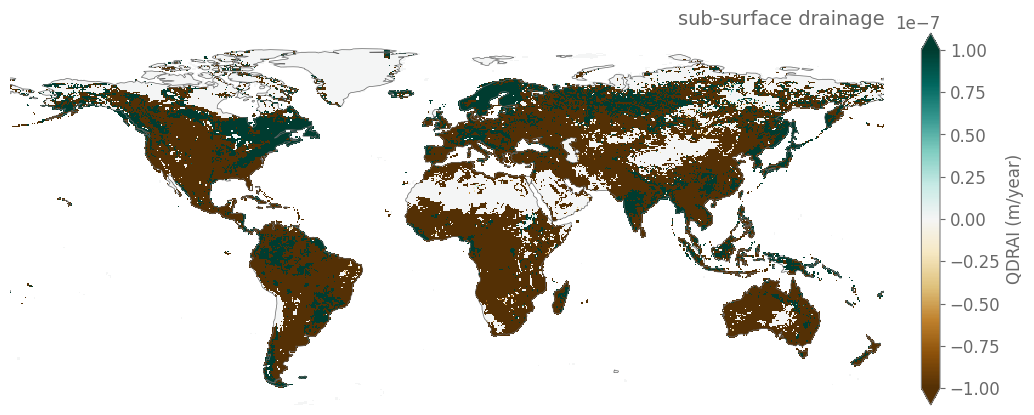

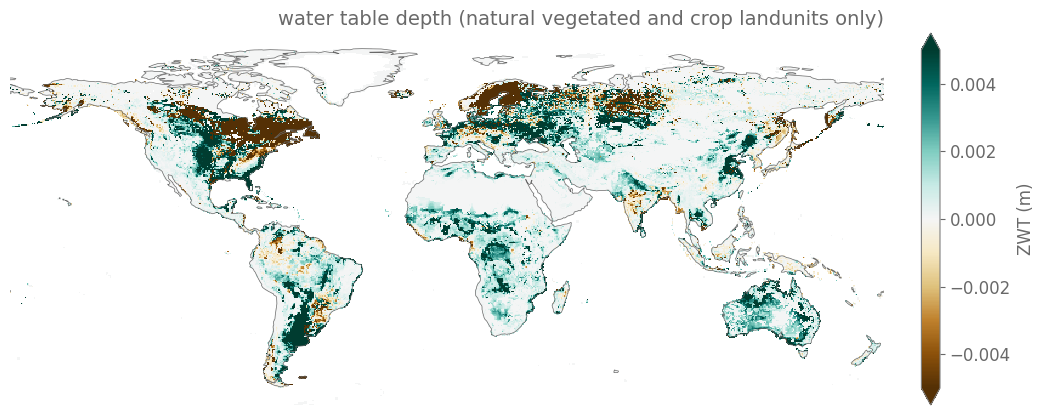

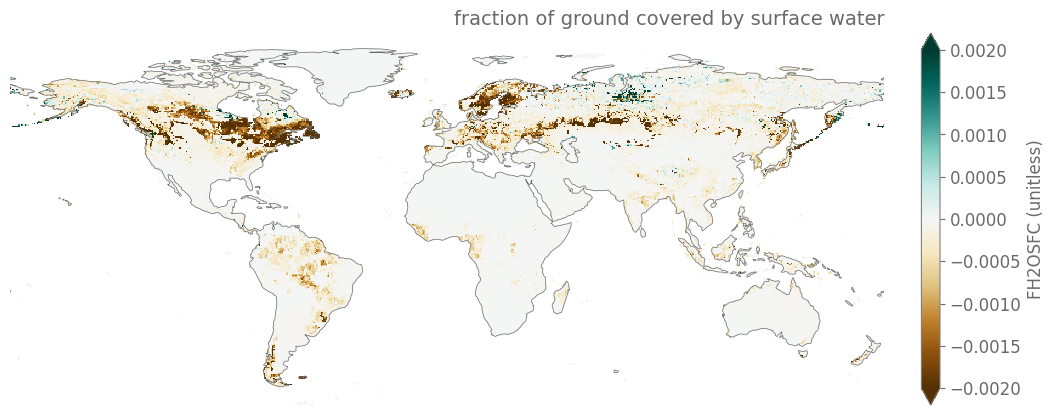

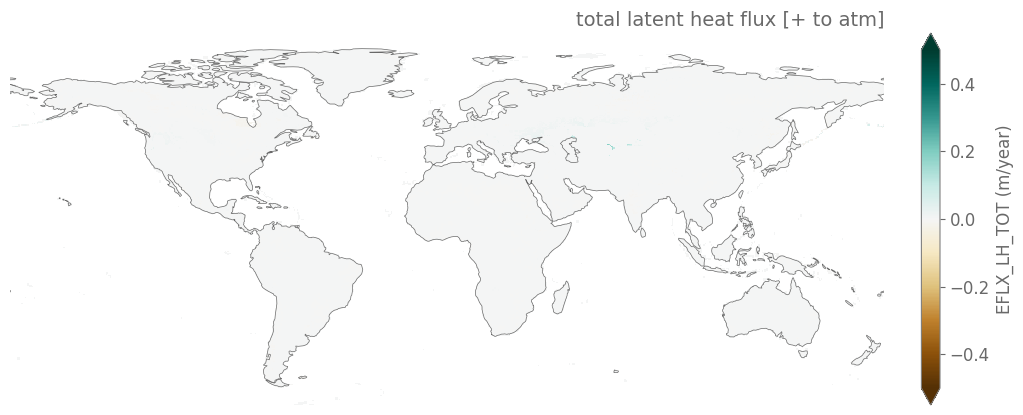

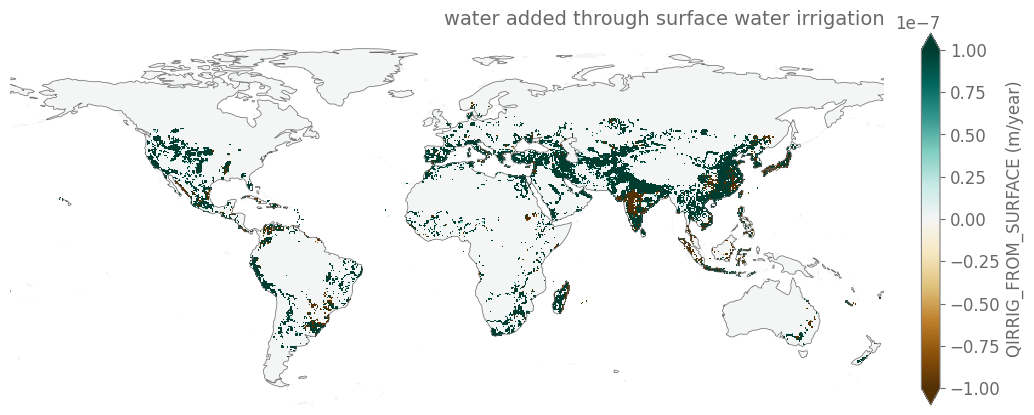

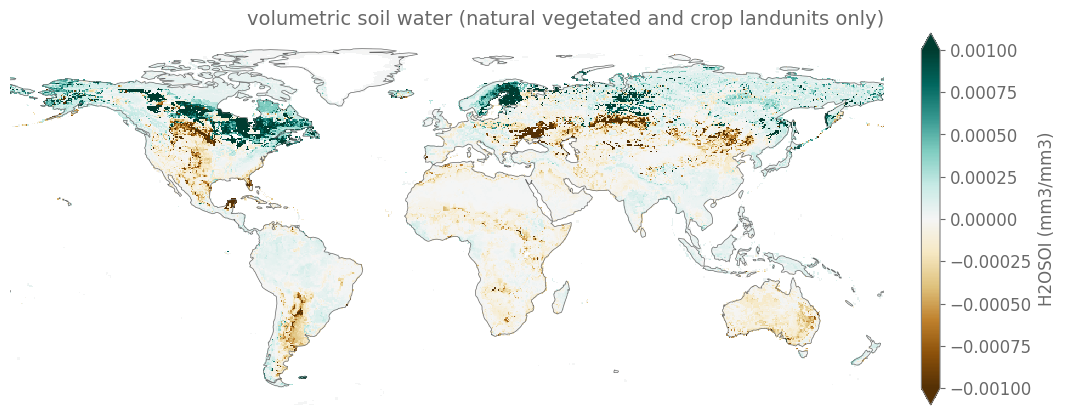

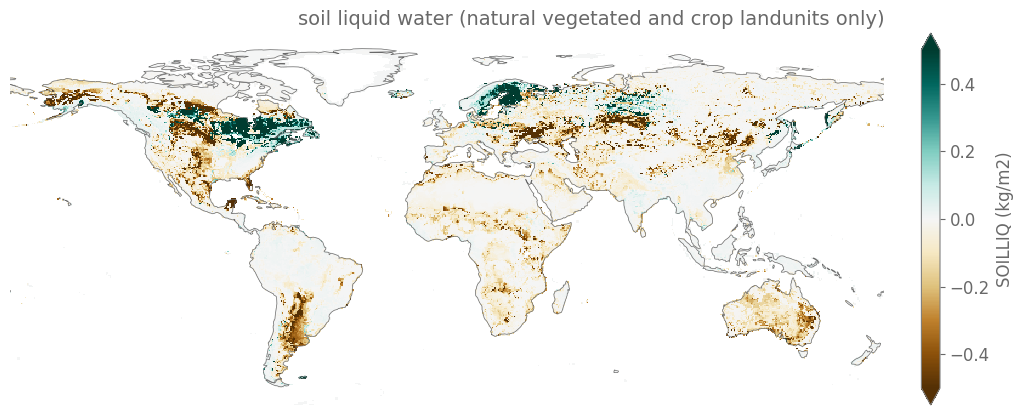

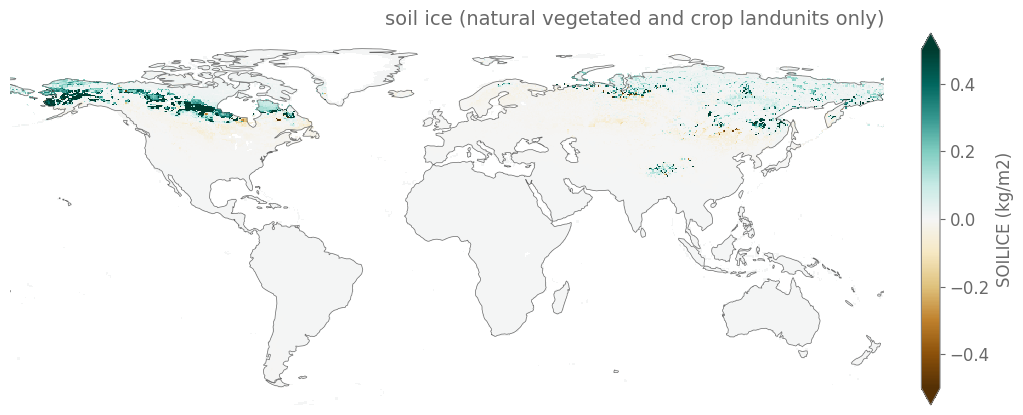

In [16]:
d_vlims = { "QDRAI"         : [-1e-7,1e-7], 
           "QINFL"         : [-1e-5,1e-5],
           "QOVER"         : [-1e-7,1e-7],
           "TOTSOILLIQ"    : [-20,20],
           "TOTSOILICE"    :  [-20,20], 
           "SOILWATER_10CM": [-4,4],
           "TWS"           : [-8,8],
           "ZWT"           : [-0.005,0.005], 
           "FH2OSFC"       : [-0.002,0.002], 
           "QINFL"         : [-1e-5,1e-5],
           "EFLX_LH_TOT"         : [-0.5,0.5],
            "H2OSOI"         : [-1e-3,1e-3],
           "SOILLIQ"         : [-0.5,0.5],
           "SOILICE"         : [-0.5,0.5],
           "QIRRIG_FROM_SURFACE"         : [-1e-7,1e-7],}

# 
for i, variable in enumerate(variables): 


    da_delta = ds_delta[variable]
    
    if 'levsoi' in da_delta.dims: 
        da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
        
        
    da_delta.attrs = ds_ctl[variable].attrs
    
    if variable in d_vlims.keys(): 

        plot_delta_map(da_delta, plot_regions=False, vlims=d_vlims[variable], calcsum=False, cmap='BrBG')

## relative differences

In [ ]:
d_vlims = {"QDRAI"         : [-5,5], 
           "QINFL"         :  [-5,5], 
           "QOVER"         :  [-1,1], 
           "TOTSOILLIQ"    :  [-1,1], 
           "TOTSOILICE"    :  [-10,10], 
           "SOILWATER_10CM":  [-5,5], 
           "TWS"           :  [-1,1], 
           "ZWT"           :  [-1,1], 
           "FH2OSFC"      :  [-5,5], 
           "EFLX_LH_TOT"         : [-1,1],
            "H2OSOI"         : [-0.1,0.1],
            "SOILLIQ"         : [-1,1],
            "SOILICE"         : [-20,20],
           "QIRRIG_FROM_SURFACE"         : [-1,1]}



for i, variable in enumerate(variables): 
    

    da_delta = ds_delta[variable] / ds_ctl[variable] *100
    if 'levsoi' in da_delta.dims: 
        da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
    
    da_delta.attrs = ds_ctl[variable].attrs
    da_delta.attrs['units'] = '%'
    if variable in d_vlims.keys(): 

        ax = plot_delta_map(da_delta, plot_regions=False, vlims=d_vlims[variable], calcsum=False, cmap='BrBG')
        
        #regionmask.defined_regions.srex.plot(ax=ax,add_ocean=False, coastlines=False, add_label=True)

### Different soil layers

First 10 cms: decrease, then increase. 

In [24]:
variable = 'H2OSOI'

for n,i in enumerate(ds_delta.levsoi): 
    
    da_delta = ds_delta[variable].sel(levsoi=i) / ds_4pct[variable].sel(levsoi=i) *100
    da_delta.attrs = ds_ctl[variable].attrs
    da_delta.attrs['units'] = '%'
    da_delta.attrs['long_name'] =  ds_ctl[variable].attrs['long_name'] + '(soil level: '+str(i.values)+', depth: '+str(levsoi_depth[n])+' m)'
    
    plot_delta_map(da_delta, plot_regions=False, vlims=[-5,5], calcsum=False, cmap='BrBG')

NameError: name 'ds_4pct' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw=dict(projection=ccrs.Robinson()))
regionmask.defined_regions.ar6.land.plot(ax=ax, projection=ccrs.Robinson(), label="abbrev", add_ocean=True)

## Deltas of water balance terms

In [ ]:
%%time 

flag_calc_wb=True

if flag_calc_wb: 

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'QIRRIG_FROM_SURFACE', "QVEGE", "QVEGT","QSOIL", "TSA"]
    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ',  'QIRRIG', "QVEGE", "QVEGT","QSOIL", "TSA"]

    d_wb_vars = {}

    ds_delta_timmean = (ds_delta).mean('time') 
    ds_ctl_timmean = ds_ctl.mean('time')

    for i,region in enumerate(region_ids):
        print(region)

        mask = regionmask.defined_regions.ar6.land.mask(ds_delta['H2OSOI'])
        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

        d_var_list = {}
        for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
            print(variable)
            da_ctl_seasmean_region = (ds_delta_timmean[variable].where(mask==region).mean(dim=('lat','lon')) / ds_ctl_timmean[variable].where(mask==region).mean(dim=('lat','lon'))).values*100

            d_var_list[variable_toplot]= da_ctl_seasmean_region

        d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

    df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
    df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_pftsoilcol.nc')

    
else: 
    
    df_wbterms = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_pftsoilcol.nc', index_col=0)

3
QDRAI
QINFL
QOVER
TOTSOILLIQ
QIRRIG_FROM_SURFACE
QVEGE
QVEGT
QSOIL
TSA
4
QDRAI
QINFL
QOVER
TOTSOILLIQ
QIRRIG_FROM_SURFACE
QVEGE
QVEGT
QSOIL


In [ ]:
fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms[[str(region)]].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(df_wbterms.index)),list(df_wbterms.index), rotation=45, ha='right')

fig.tight_layout()

## calculate cumulative irrigation amounts

In [13]:
da_ctl = ds_ctl['QIRRIG_FROM_SURFACE']
da_scen  = ds_scen['QIRRIG_FROM_SURFACE']

da_delta = da_scen - da_ctl

In [14]:
gridarea = xr.open_dataset('/scratch/snx3000/ivanderk/processing_4p1000/gridarea_0.5x0.5.nc')['cell_area']

In [52]:
da_annual_qirrig = (da_delta * 24*60*60*30).groupby('time.year').sum().compute() # mm/year


In [40]:
total_irrigation_delta = (da_annual_qirrig.mean('year')*1e-3 * gridarea).sum().values # m3/ year

print(str(np.round(total_irrigation_delta*1e-6,2)) + ' 10^6 m3/year')

2105.82 10^6 m3/year


In [72]:
control_irrigation = (da_ctl * 24*60*60*30).groupby('time.year').sum().compute() # mm/year
scen_irrigation = (da_scen * 24*60*60*30).groupby('time.year').sum().compute() # mm/year

total_irrigation_control = (control_irrigation.mean('year')*1e-3 * gridarea).sum().values # m3/ year

print(str(np.round(total_irrigation_control*1e-6,2)) + ' 10^6 m3/year')

1362509.83 10^6 m3/year


In [18]:
print(str(np.round(total_irrigation_delta/total_irrigation_control *100,2)) + ' % difference')

0.15 % difference


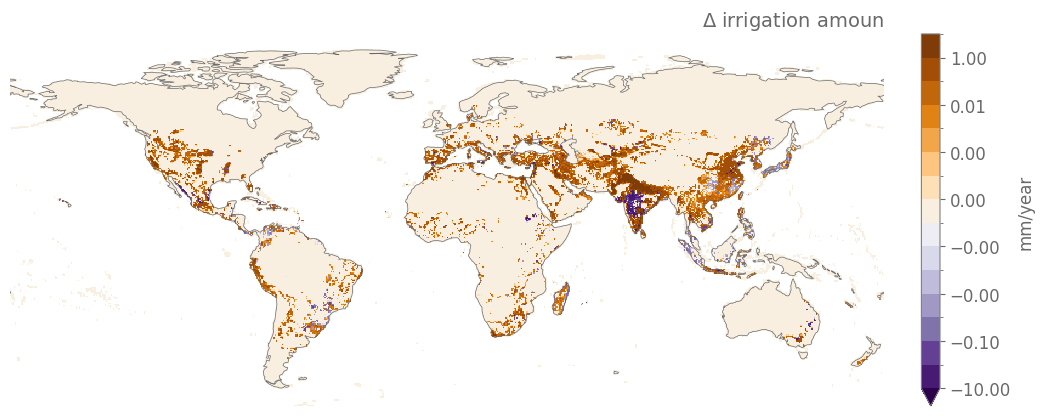

In [75]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
(scen_irrigation.mean('year') - control_irrigation.mean('year')).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

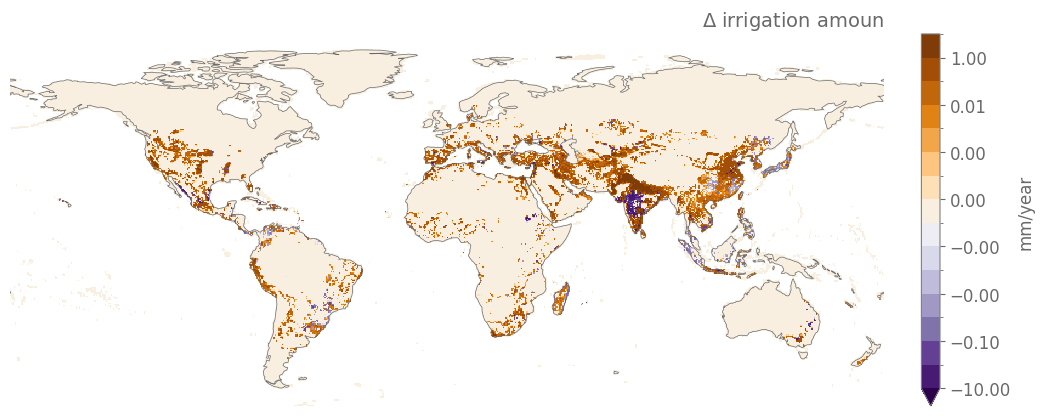

In [75]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
(scen_irrigation.mean('year') - control_irrigation.mean('year')).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

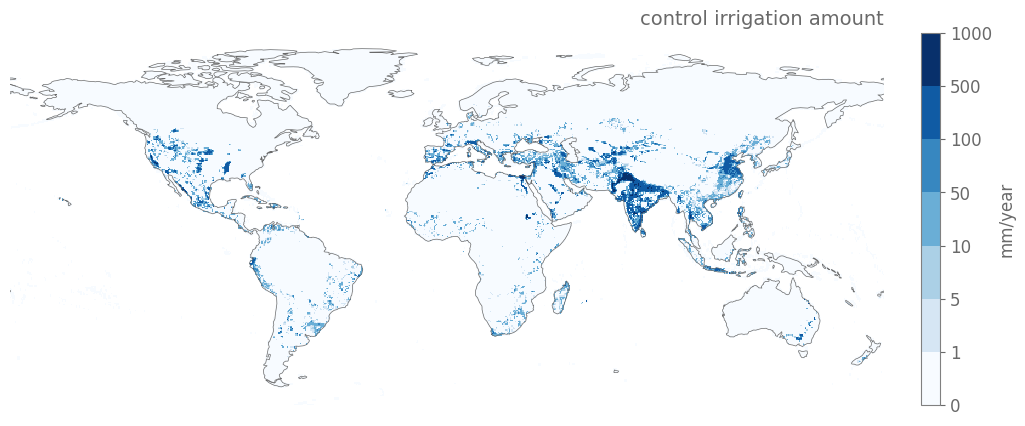

In [74]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [0,1,5,10,50, 100, 500,1000]
control_irrigation.mean('year').where(landmask).plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('control irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

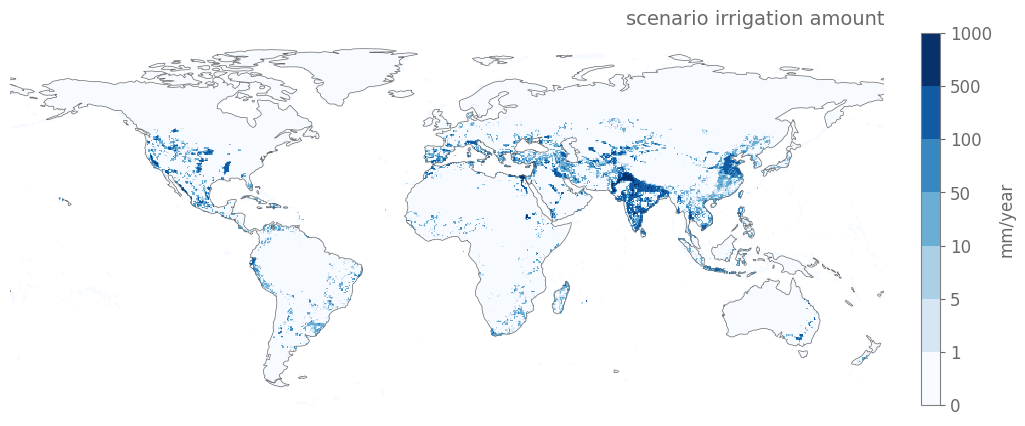

In [63]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [0,1,5,10,50, 100, 500,1000]
scen_irrigation.mean('year').where(landmask).plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('scenario irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

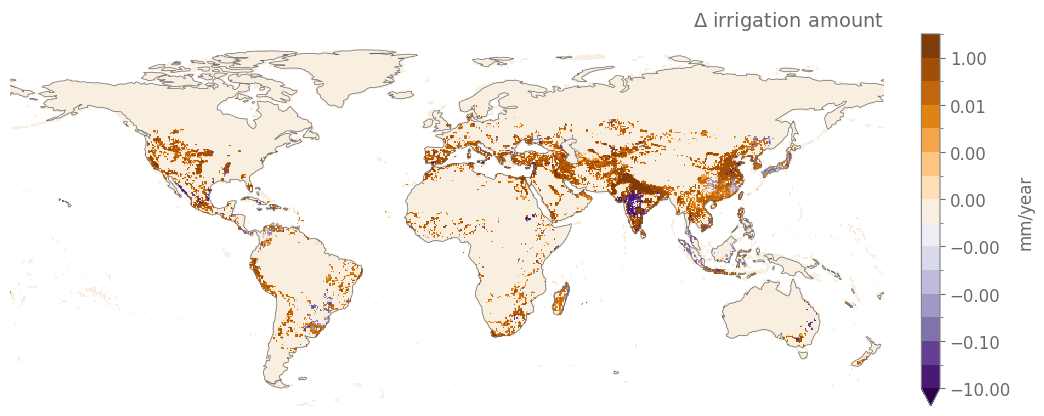

In [35]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
da_annual_qirrig.mean('year').where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

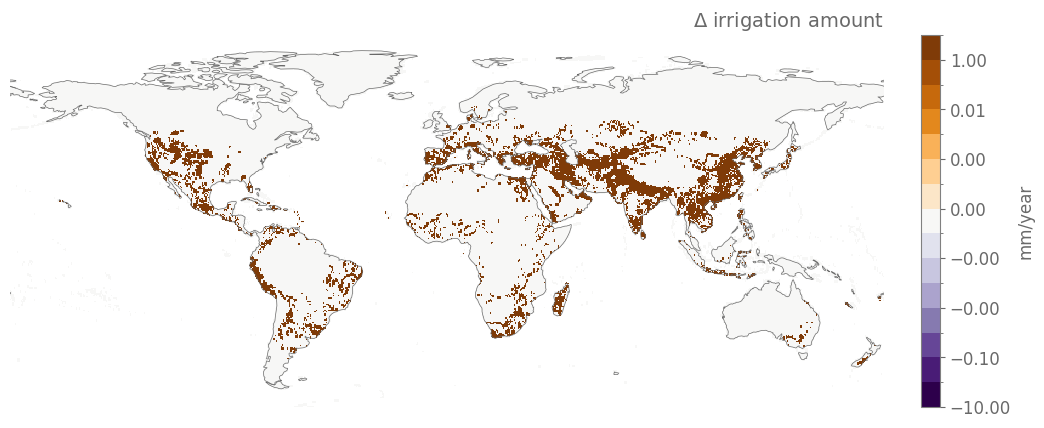

In [36]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
(da_annual_qirrig.mean('year')>0).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

In [38]:
(da_annual_qirrig.mean('year')>0).to_netcdf(procdir+'irrigation_mask.nc')

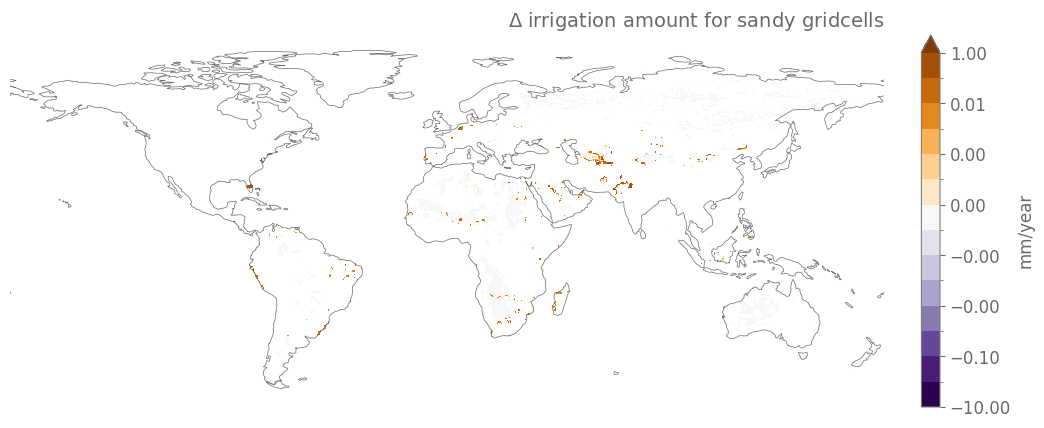

In [33]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
da_annual_qirrig.mean('year').where(landmask).where(da_sand_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount for sandy gridcells',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

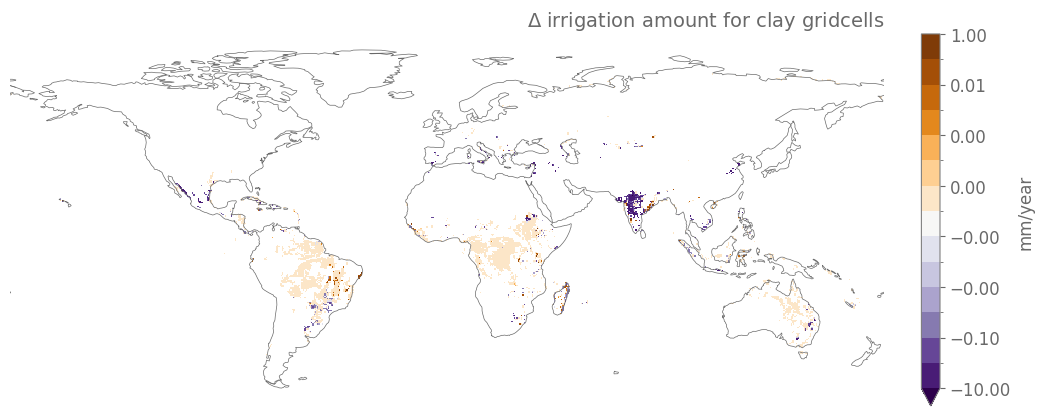

In [34]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = [-10,-1,-1e-1,-1e-2,-1e-3,-1e-4,-1e-5,-1e-6,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
da_annual_qirrig.mean('year').where(landmask).where(da_clay_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ irrigation amount for clay gridcells',loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

### calculate cumulative water stress

In [22]:
da_ctl = ds_ctl['H2OSOI'].isel(levsoi=range(0,10))
da_scen  = ds_scen['H2OSOI'].isel(levsoi=range(0,10))

da_wilting_h2osoi['levsoi'] = da_ctl.levsoi
da_wilting_h2osoi_scen['levsoi'] = da_ctl.levsoi

In [23]:
da_stress_cumulative_ctl = calc_annual_cumulative_stress(da_ctl, da_wilting_h2osoi) 
da_stress_cumulative_scen = calc_annual_cumulative_stress(da_scen, da_wilting_h2osoi_scen) 

da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

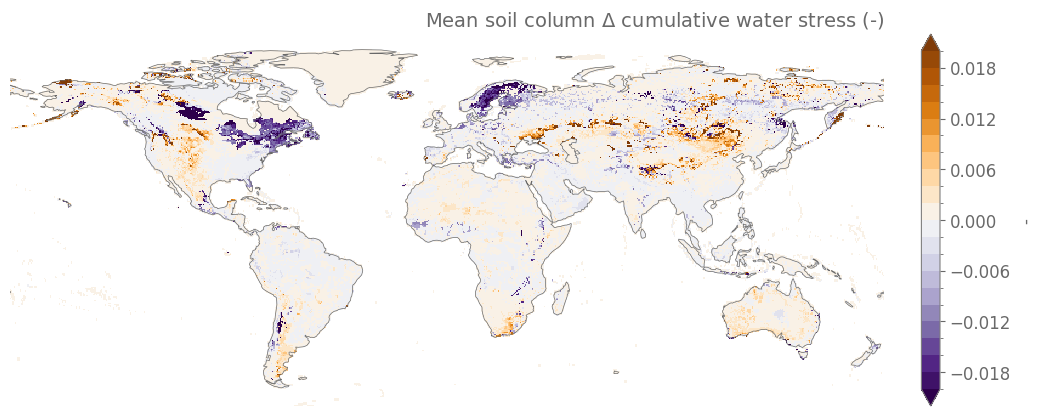

In [25]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.02,0.022,0.002)
da_delta_stress.weighted(da_delta_stress.levsoi).mean('levsoi').where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': '-', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean soil column $\Delta$ cumulative water stress (-)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

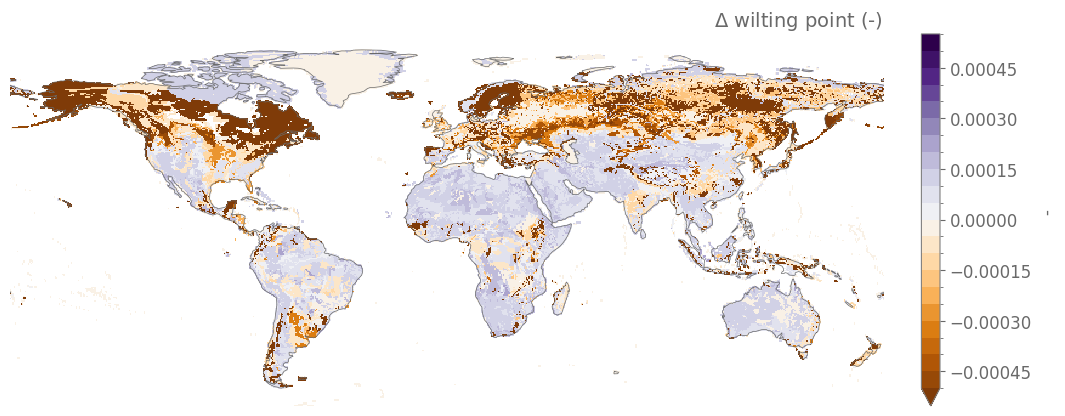

In [23]:
delta_wilting = da_wilting_h2osoi_scen - da_wilting_h2osoi
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.0005,0.00055,0.00005)
delta_wilting.weighted(da_delta_stress.levsoi).mean('levsoi').where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': '-', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('$\Delta$ wilting point (-) ', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

## water stress for crop PFT

In [28]:
variable = 'H2OSOI'

pft_list_crops = [15,16]
pft_int = pft_list_crops[0]
da_wilting_h2osoi['levsoi'] = da_ctl.levsoi
da_wilting_h2osoi_scen['levsoi'] = da_ctl.levsoi

da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable).squeeze().isel(levsoi=range(0,10))
da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable).squeeze().isel(levsoi=range(0,10))

da_stress_cumulative_ctl  = calc_annual_cumulative_stress(da_pft_ctl,  da_wilting_h2osoi) 
da_stress_cumulative_scen = calc_annual_cumulative_stress(da_pft_scen, da_wilting_h2osoi_scen) 

da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

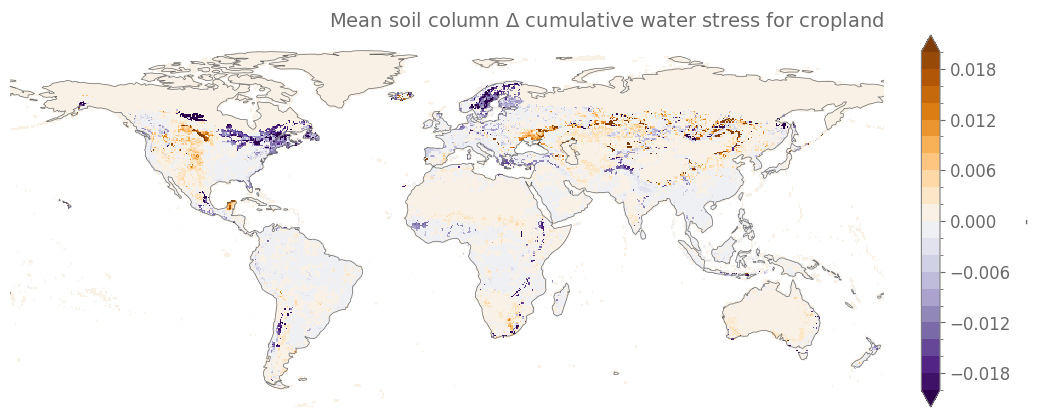

In [40]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.02,0.022,0.002)
da_delta_stress.weighted(da_delta_stress.levsoi).mean('levsoi').where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': '-', 'fraction': 0.02, 'pad': 0.04}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean soil column $\Delta$ cumulative water stress for cropland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

In [41]:
variable = 'H2OSOI'

pft_list_crops = [15,16]
pft_int = pft_list_crops[1]
da_wilting_h2osoi['levsoi'] = da_ctl.levsoi
da_wilting_h2osoi_scen['levsoi'] = da_ctl.levsoi

da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable).squeeze().isel(levsoi=range(0,10))
da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable).squeeze().isel(levsoi=range(0,10))

da_stress_cumulative_ctl  = calc_annual_cumulative_stress(da_pft_ctl,  da_wilting_h2osoi) 
da_stress_cumulative_scen = calc_annual_cumulative_stress(da_pft_scen, da_wilting_h2osoi_scen) 

da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

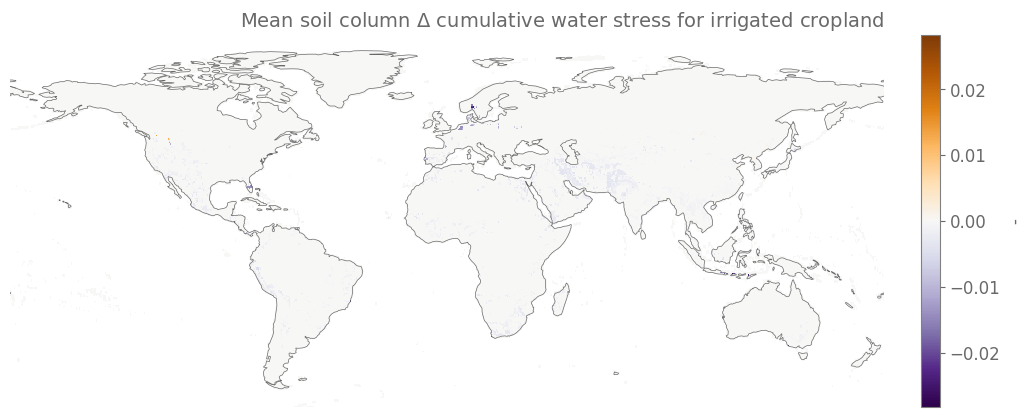

In [44]:
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.02,0.022,0.002)
da_delta_stress.weighted(da_delta_stress.levsoi).mean('levsoi').where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': '-', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean soil column $\Delta$ cumulative water stress for irrigated cropland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

#### delta H2SPOI

In [132]:
variable= 'H2OSOI'

i=0
region=3

ax = axes[i]

region_name = regionmask.defined_regions.ar6.land[region].name
region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev


da_ctl_seasmean_region = ds_ctl_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))
da_ctl_seasmean_region_qroot = ds_ctl_seasmean['QROOTSINK'].where(mask==region).mean(dim=('lat','lon'))

da_4pct_seasmean_region = ds_4pct_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))


da_delta_region = (da_4pct_seasmean_region - da_ctl_seasmean_region)/da_ctl_seasmean_region *100
levels = np.arange(-1,1.1,0.1)
levels_ticks =  np.arange(-1,1.2,0.2)

ticks = levels_ticks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


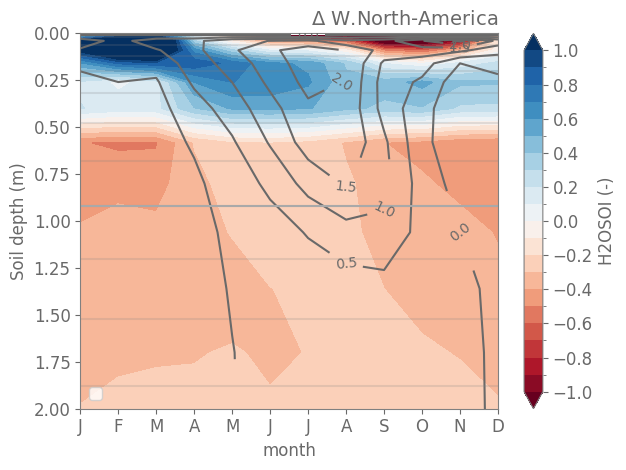

In [151]:
fig, ax = plt.subplots()

da_delta_region.plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label': da_ctl_seasmean_region.name+' (-)', 'ticks':ticks}, levels=levels)

levels_qroot = np.arange(0,2.75e-6,0.5e-6)
cs = da_ctl_seasmean_region_qroot.plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, colors='dimgray')
ax.clabel(cs, inline=True, fontsize=10)


ax.set_title('$\Delta$ '+region_name, loc='right')
ax.set_ylim([plotting_depth,0])
#da_ctl_seasmean_region_4p1000.plot(ax=ax, label='4p100', color='k')

ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

ax.legend(loc='lower left')
ax.set_ylabel('Soil depth (m)')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
fig.tight_layout()

### Do calculations for regional averages

In [12]:
%%time

# calculate regional averages

flag_calc_regional_means = True

variable= 'H2OSOI'

if flag_calc_regional_means: 
    
    ds_ctl_seasmean = ds_ctl.groupby('time.month').mean(skipna=True)
    ds_scen_seasmean = ds_scen.groupby('time.month').mean(skipna=True)
    
    da_ctl_relsat = (ds_ctl_seasmean['H2OSOI']/ds_ctl_seasmean['watsat'].rename({'levgrnd':'levsoi'})).assign_attrs({'name':'Saturation fration'})
    da_scen_relsat = (ds_scen_seasmean['H2OSOI']/ds_scen_seasmean['watsat'].rename({'levgrnd':'levsoi'})).assign_attrs({'name':'Saturation fration'})

    d_ctl_region = {}
    d_scen_region = {}
    d_delta_region = {}
    d_ctl_region_qroot = {}

    d_ctl_relsat_region = {}
    d_scen_relsat_region = {}
    d_delta_relsat_region = {}
    
    for i,region in enumerate(region_ids):

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

        da_ctl_seasmean_region = ds_ctl_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))
        da_scen_seasmean_region = ds_scen_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))

        da_delta_region = (da_scen_seasmean_region - da_ctl_seasmean_region)/da_ctl_seasmean_region *100
        
        d_ctl_region[region_name]       = da_ctl_seasmean_region
        d_scen_region[region_name]      = da_scen_seasmean_region       
        d_delta_region[region_name]     = da_delta_region
        

        da_ctl_relsat_region = da_ctl_relsat.where(mask==region).mean(dim=('lat','lon'))
        da_scen_relsat_region = da_scen_relsat.where(mask==region).mean(dim=('lat','lon'))

        da_delta_relsat_region = (da_scen_relsat_region - da_ctl_relsat_region)/da_ctl_relsat_region *100
        da_delta_relsat_region.attrs = {'units':ds_ctl_seasmean[variable].attrs['units'],'name':'Saturation fration'}
        
        d_ctl_relsat_region[region_name]    = da_ctl_relsat_region
        d_scen_relsat_region[region_name]   = da_scen_relsat_region
        d_delta_relsat_region[region_name]  = da_delta_relsat_region        
        
        da_ctl_seasmean_region_qroot = ds_ctl_seasmean['QROOTSINK'].where(mask==region).mean(dim=('lat','lon'))
        d_ctl_region_qroot[region_name] = da_ctl_seasmean_region_qroot       


CPU times: user 3.81 s, sys: 17.9 ms, total: 3.83 s
Wall time: 3.79 s


#### Delta volumetric water content

CPU times: user 32min 28s, sys: 19min 38s, total: 52min 6s
Wall time: 57min 9s


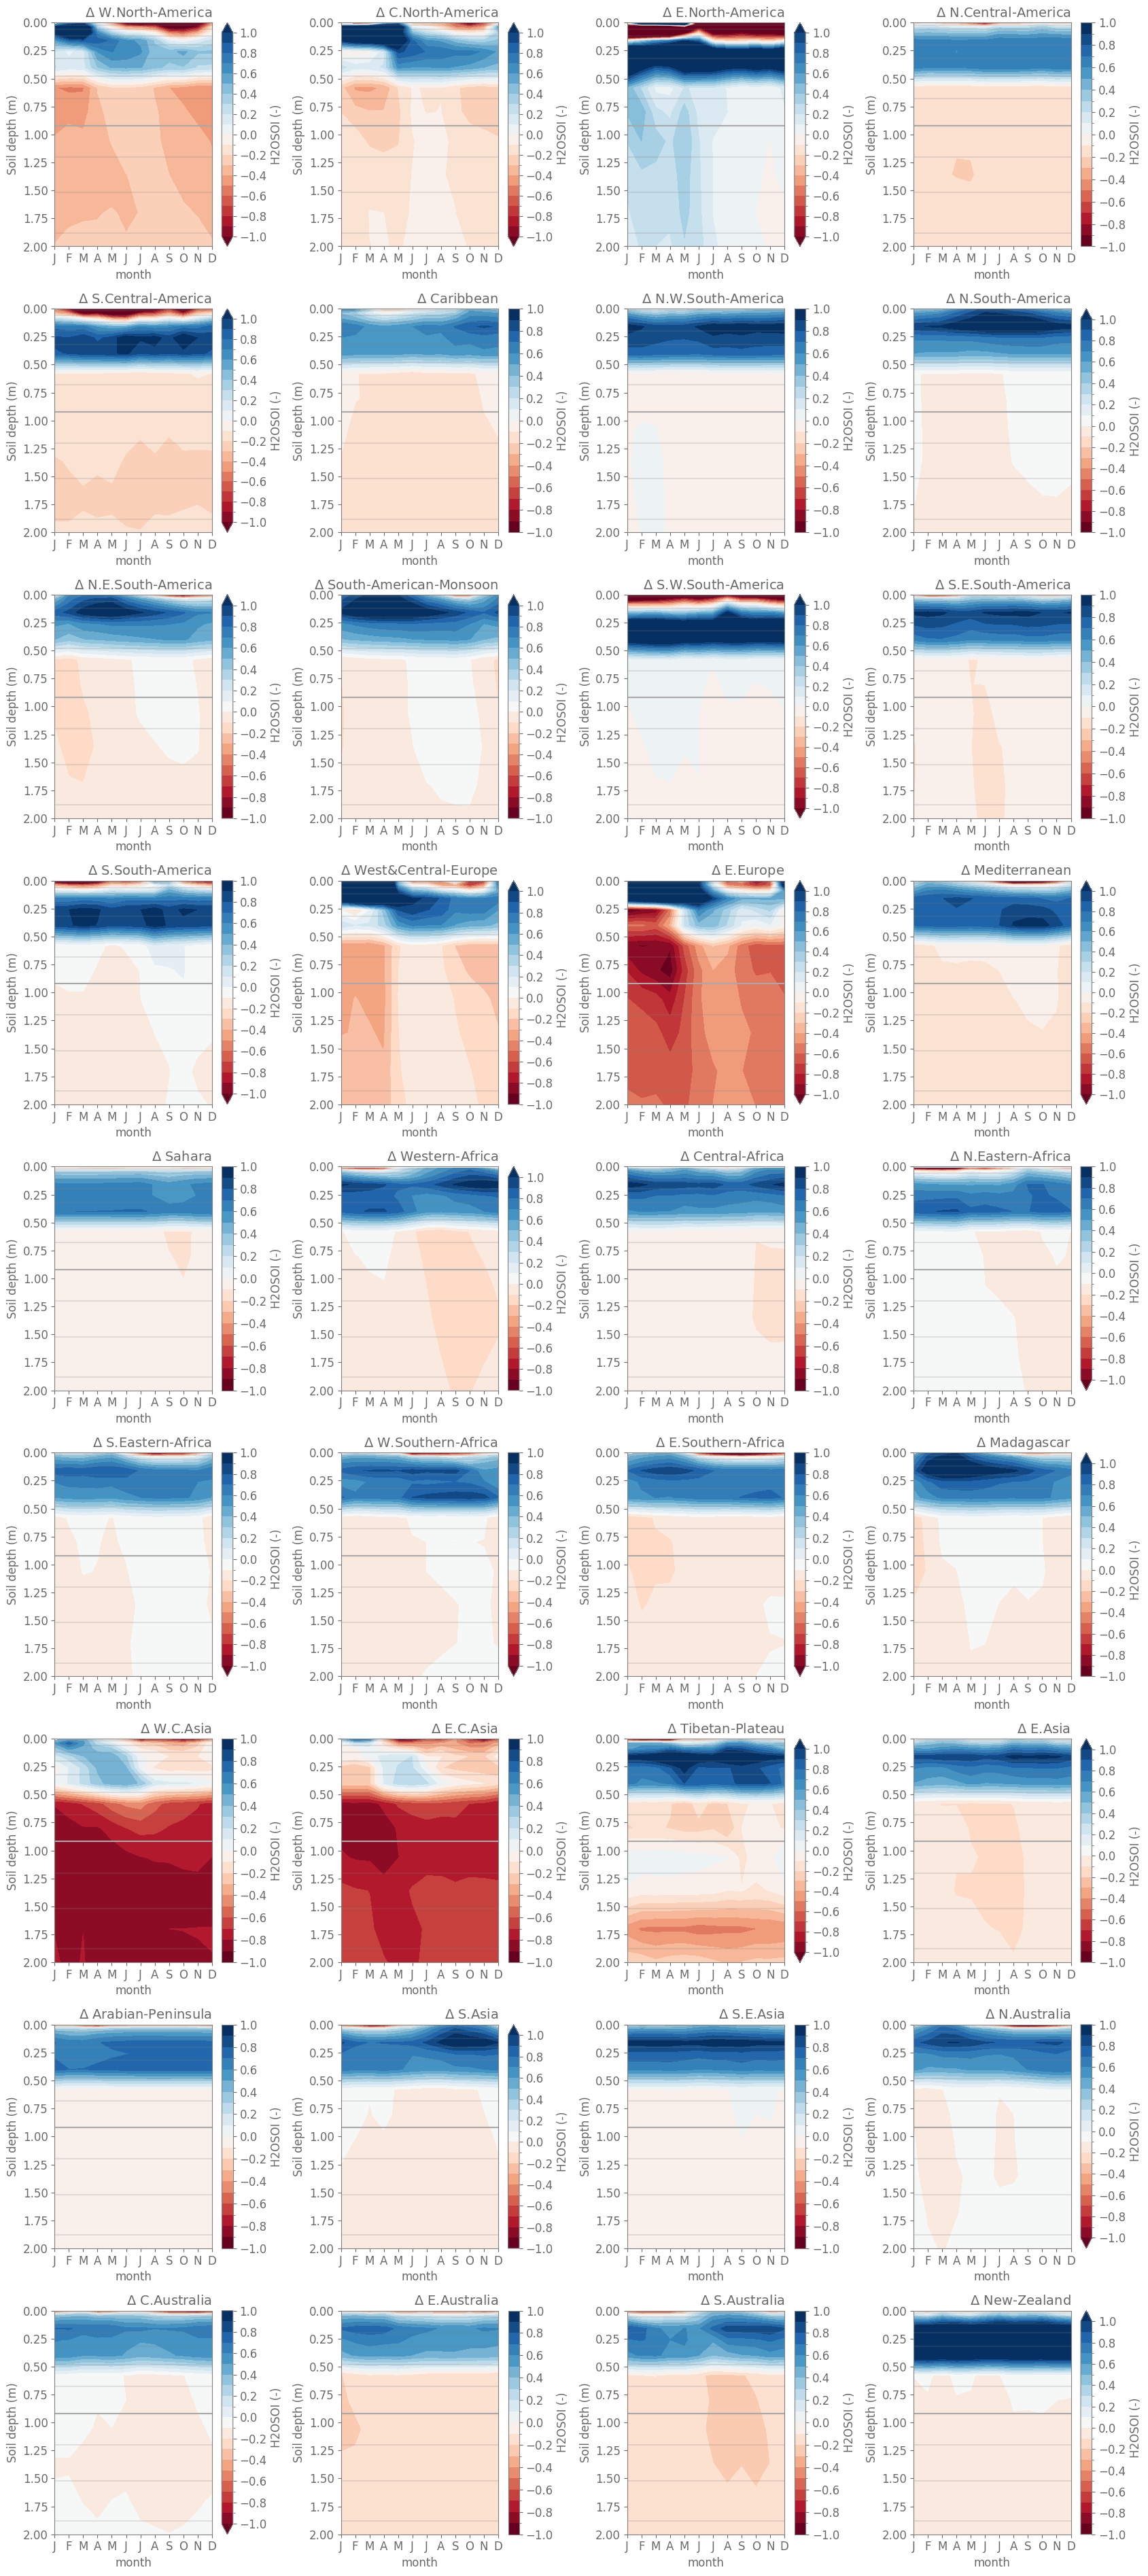

In [40]:
%%time

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

flag_plot_rootuptake = True

for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

     
    levels = np.arange(-1,1.1,0.1)
    levels_ticks =  np.arange(-1,1.2,0.2)
    ticks = levels_ticks
    
    d_delta_region[region_name].plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label': da_ctl_seasmean_region.name+' (-)', 'ticks':ticks}, levels=levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([plotting_depth,0])
    
    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = d_ctl_region_qroot[region_name].plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot) #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()
    

In [ ]:
%%time

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

flag_plot_rootuptake = True

for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

     
    levels = np.arange(-1,1.1,0.1)
    levels_ticks =  np.arange(-1,1.2,0.2)
    ticks = levels_ticks
    
    d_delta_region[region_name].plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label': da_ctl_seasmean_region.name+' (-)', 'ticks':ticks}, levels=levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([plotting_depth,0])
    
    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = d_ctl_region_qroot[region_name].plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot) #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()
    

#### Control volumetric water content

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

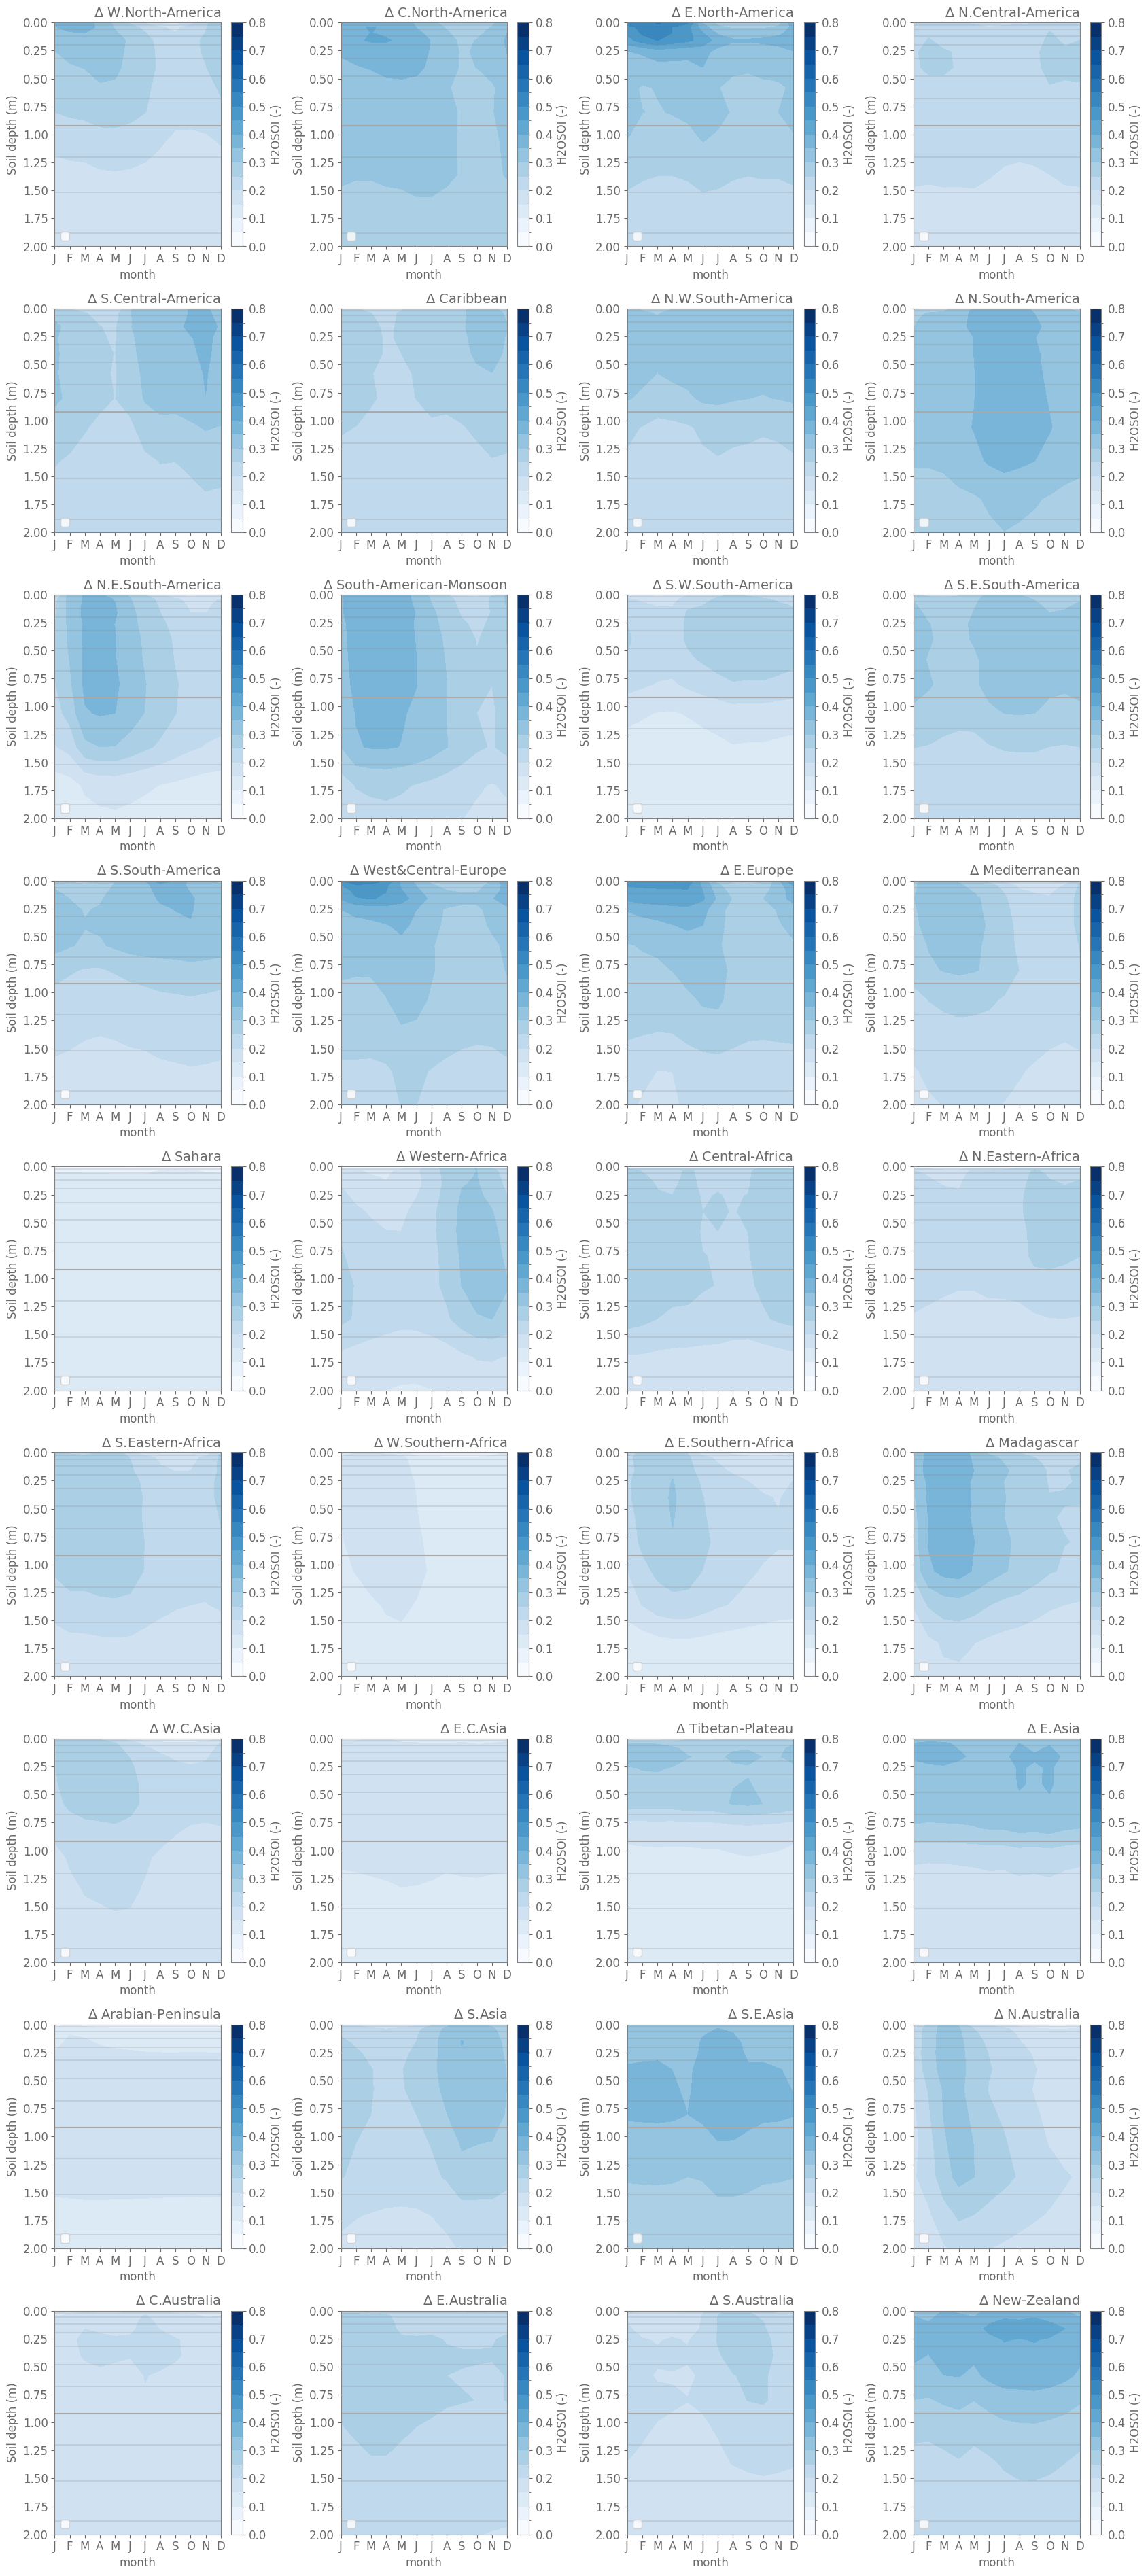

In [41]:
variable= 'H2OSOI'

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev


    levels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6,0.65,0.7,0.75,0.8]
    levels_ticks = [0,0.1,0.2,0.3,0.4,0.5, 0.6,0.7,0.8]

    ticks = levels_ticks
    
    d_ctl_region[region_name].plot.contourf(ax=ax, x='month', y='levsoi', cmap='Blues', cbar_kwargs={'label': da_ctl_seasmean_region.name+' (-)', 'ticks':ticks}, levels=levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([plotting_depth,0])

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### relative saturation of control run

In [ ]:
variable= 'H2OSOI'

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels = [-0.6,-0.55,-0.5,-0.44,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6]
    ticks = [-0.6,-0.4,-0.2,-0.05,0.05,0.2,0.4, 0.6]    
    
    d_delta_relsat_region[region_name].plot.contourf(ax=ax, x='month', y='levsoi', cmap='Blues', cbar_kwargs={'label':' Saturation ratio (-)', 'ticks':ticks}, levels= levels)
    ax.set_title(region_name, loc='right')
    ax.set_ylim([plotting_depth,0])

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### plot control case water stress

In [16]:
variable= 'H2OSOI'

mask = regionmask.defined_regions.ar6.land.mask(ds_ctl_seasmean[variable])

region_ids = np.arange(0,44)
fig, axes = plt.subplots(11,4,figsize=(14,50))
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    da_delta_region = (ds_ctl_seasmean['H2OSOI'][:,:10,:,:] - da_wilting_h2osoi).where(mask==region).mean(dim=('lat','lon'))
    da_delta_region = da_delta_region.where(da_delta_region>=0)
    levels = [0,0.05,0.1,0.15,0.2,0.25,0.3]
    levels_ticks = [0,0.05,0.2,0.4, 0.6, 0.8,1]

    ticks = levels
    
    
    da_delta_region.plot.contourf(ax=ax, x='month', y='levsoi', cmap='Reds', cbar_kwargs={'label':' (%)', 'ticks':ticks}, levels= levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([8,0])
    #da_ctl_seasmean_region_zwt.plot(ax=ax, label='CTL', color='k')
    #da_ctl_seasmean_region_4p1000.plot(ax=ax, label='4p100', color='k')

    #ax.legend(loc='lower left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

NameError: name 'ds_ctl_seasmean' is not defined

## difference in WILTING POINTS 4PCT-CTL

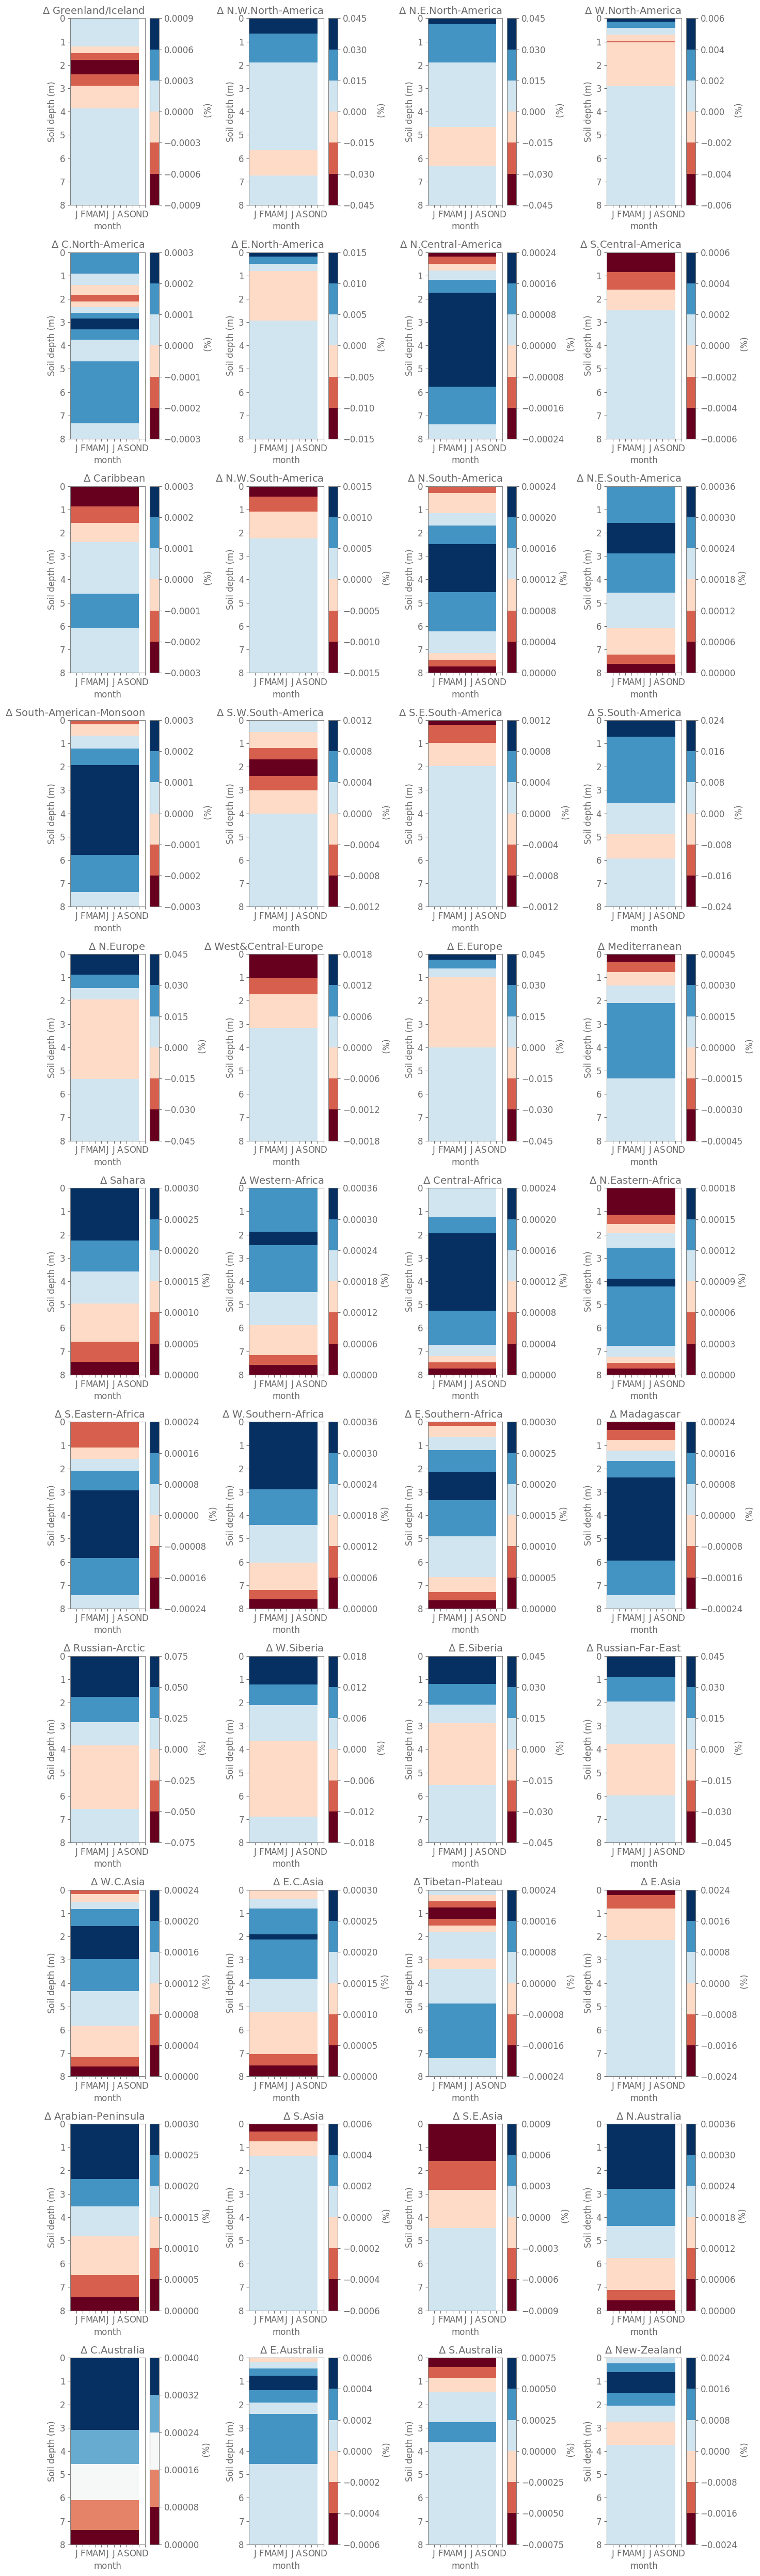

In [40]:
variable= 'H2OSOI'

mask = regionmask.defined_regions.ar6.land.mask(ds_ctl_seasmean[variable])

region_ids = np.arange(0,44)
fig, axes = plt.subplots(11,4,figsize=(14,50))
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    
    da_seasmean_region = da_wilting_h2osoi.expand_dims(dim={"month": 12}).where(mask==region).mean(dim=('lat','lon'))
    da_seasmean_region_4pct = da_wilting_h2osoi_4pct.expand_dims(dim={"month": 12}).where(mask==region).mean(dim=('lat','lon'))

    da_delta_region = da_seasmean_region_4pct - da_seasmean_region
    levels = [0,0.05,0.1,0.15,0.2,0.25,0.3]
    levels_ticks = [0,0.05,0.2,0.4, 0.6, 0.8,1]

    ticks = levels
    
    
    da_delta_region.plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' (%)'})#, levels= levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([8,0])
    #da_ctl_seasmean_region_zwt.plot(ax=ax, label='CTL', color='k')
    #da_ctl_seasmean_region_4p1000.plot(ax=ax, label='4p100', color='k')

    #ax.legend(loc='lower left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### Difference in water stress per region

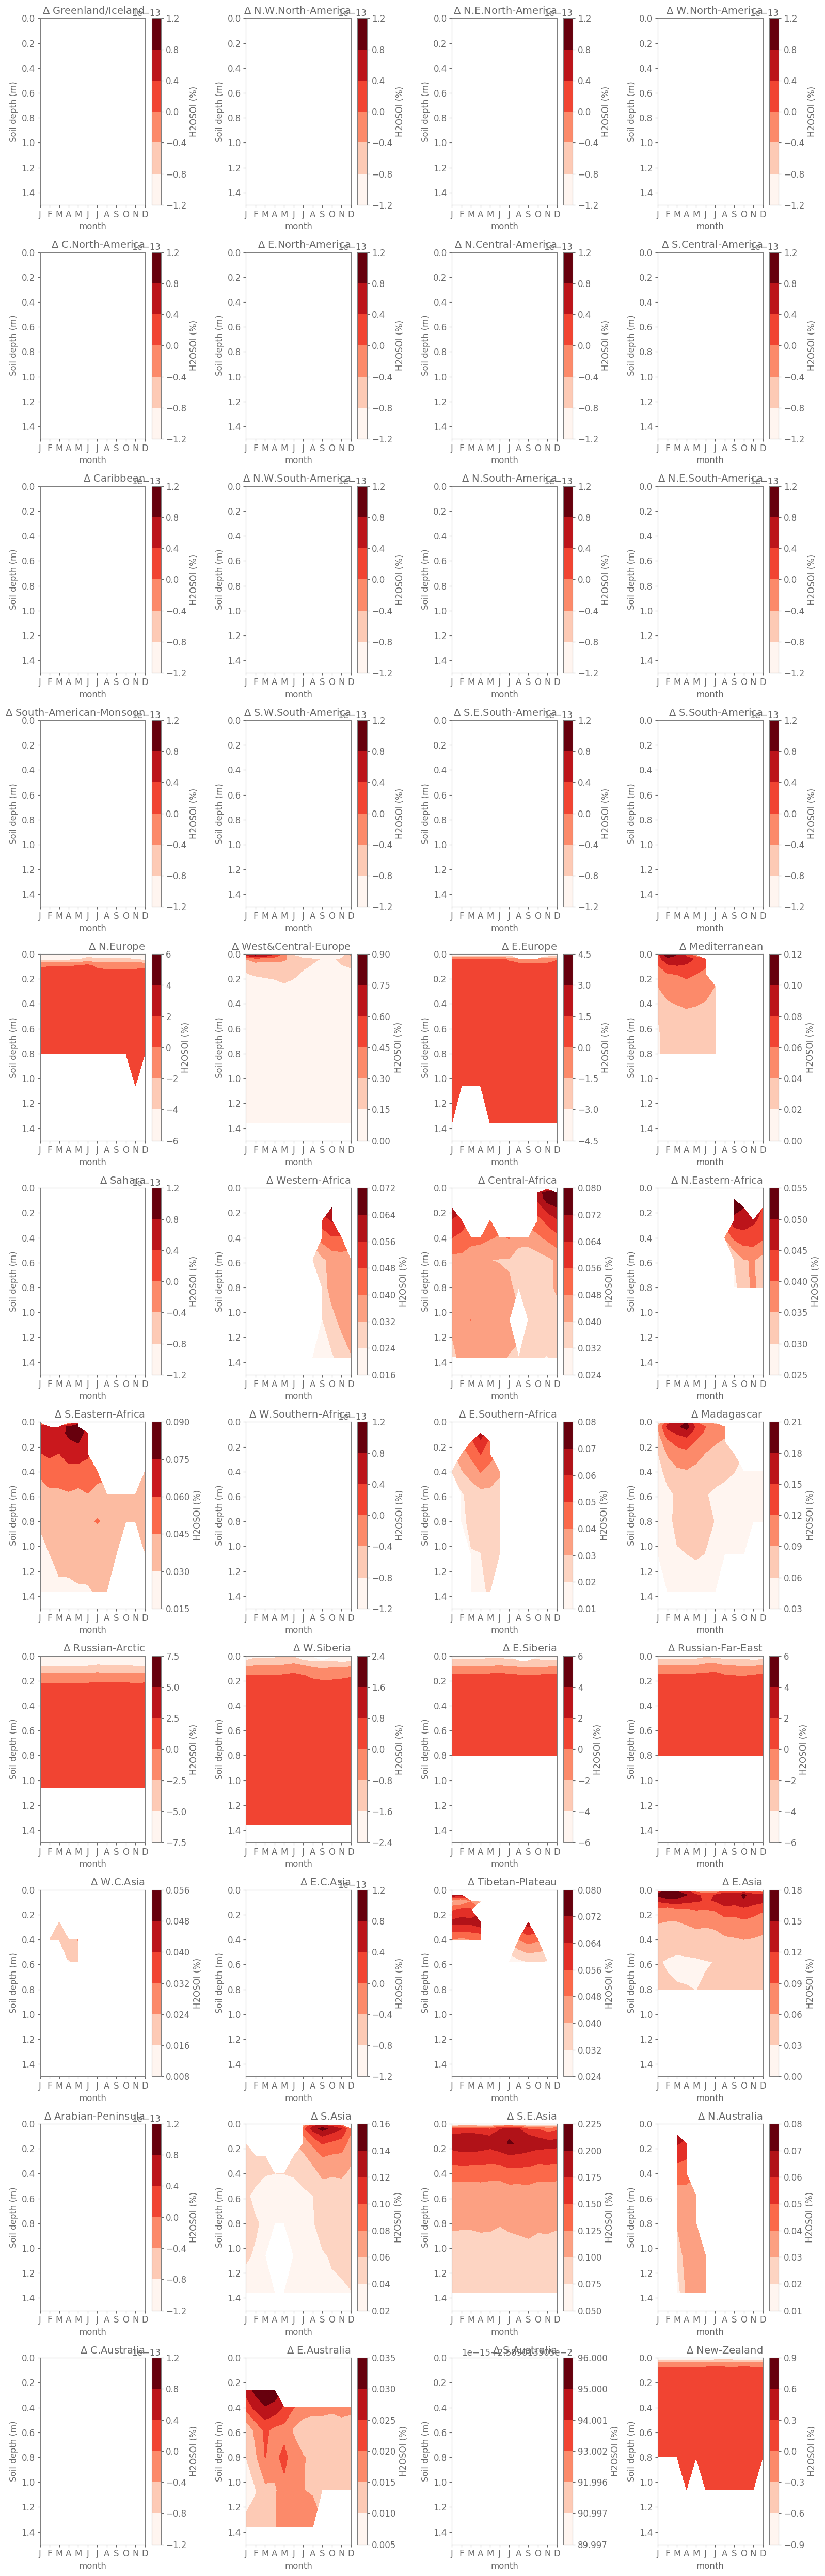

In [31]:
# zoom on regions highly active

variable= 'H2OSOI'

mask = regionmask.defined_regions.ar6.land.mask(ds_ctl_seasmean[variable])

region_ids = np.arange(0,44)
fig, axes = plt.subplots(11,4,figsize=(16,50))
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    

    da_ctl_seasmean_region = ds_ctl_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))
    da_4pct_seasmean_region = ds_4pct_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))
    da_wilting_h2osoi_region = da_wilting_h2osoi.where(mask==region).mean(dim=('lat','lon'))
    da_wilting_h2osoi_4pct_region = da_wilting_h2osoi_4pct.where(mask==region).mean(dim=('lat','lon'))

    da_delta_region = (da_4pct_seasmean_region - da_ctl_seasmean_region)/da_ctl_seasmean_region *100
    da_delta_region.attrs = {'units':ds_ctl_seasmean[variable].attrs['units']}
    
    da_ctl_waterstress_region = da_ctl_seasmean_region[:,:10] - da_wilting_h2osoi_region
    da_4pct_waterstress_region = da_4pct_seasmean_region[:,:10] - da_wilting_h2osoi_4pct_region
    da_delta_waterstress_region = (da_4pct_waterstress_region.where(da_4pct_waterstress_region>0) - da_ctl_waterstress_region.where(da_ctl_waterstress_region>0))*100
    
    levels = [-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,0.05,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8,0.9,1]
    levels_ticks = [-1,-0.8,-0.6,-0.4,-0.2,-0.05,0.05,0.2,0.4, 0.6, 0.8,1]

    ticks = levels_ticks
    
    
    da_delta_waterstress_region.plot.contourf(ax=ax, x='month', y='levsoi', cmap='Reds', cbar_kwargs={'label': da_delta_region.name+' (%)'})#, levels= levels)
    ax.set_title('$\Delta$ '+region_name, loc='right')
    ax.set_ylim([1.5,0])
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

## Root depth differences

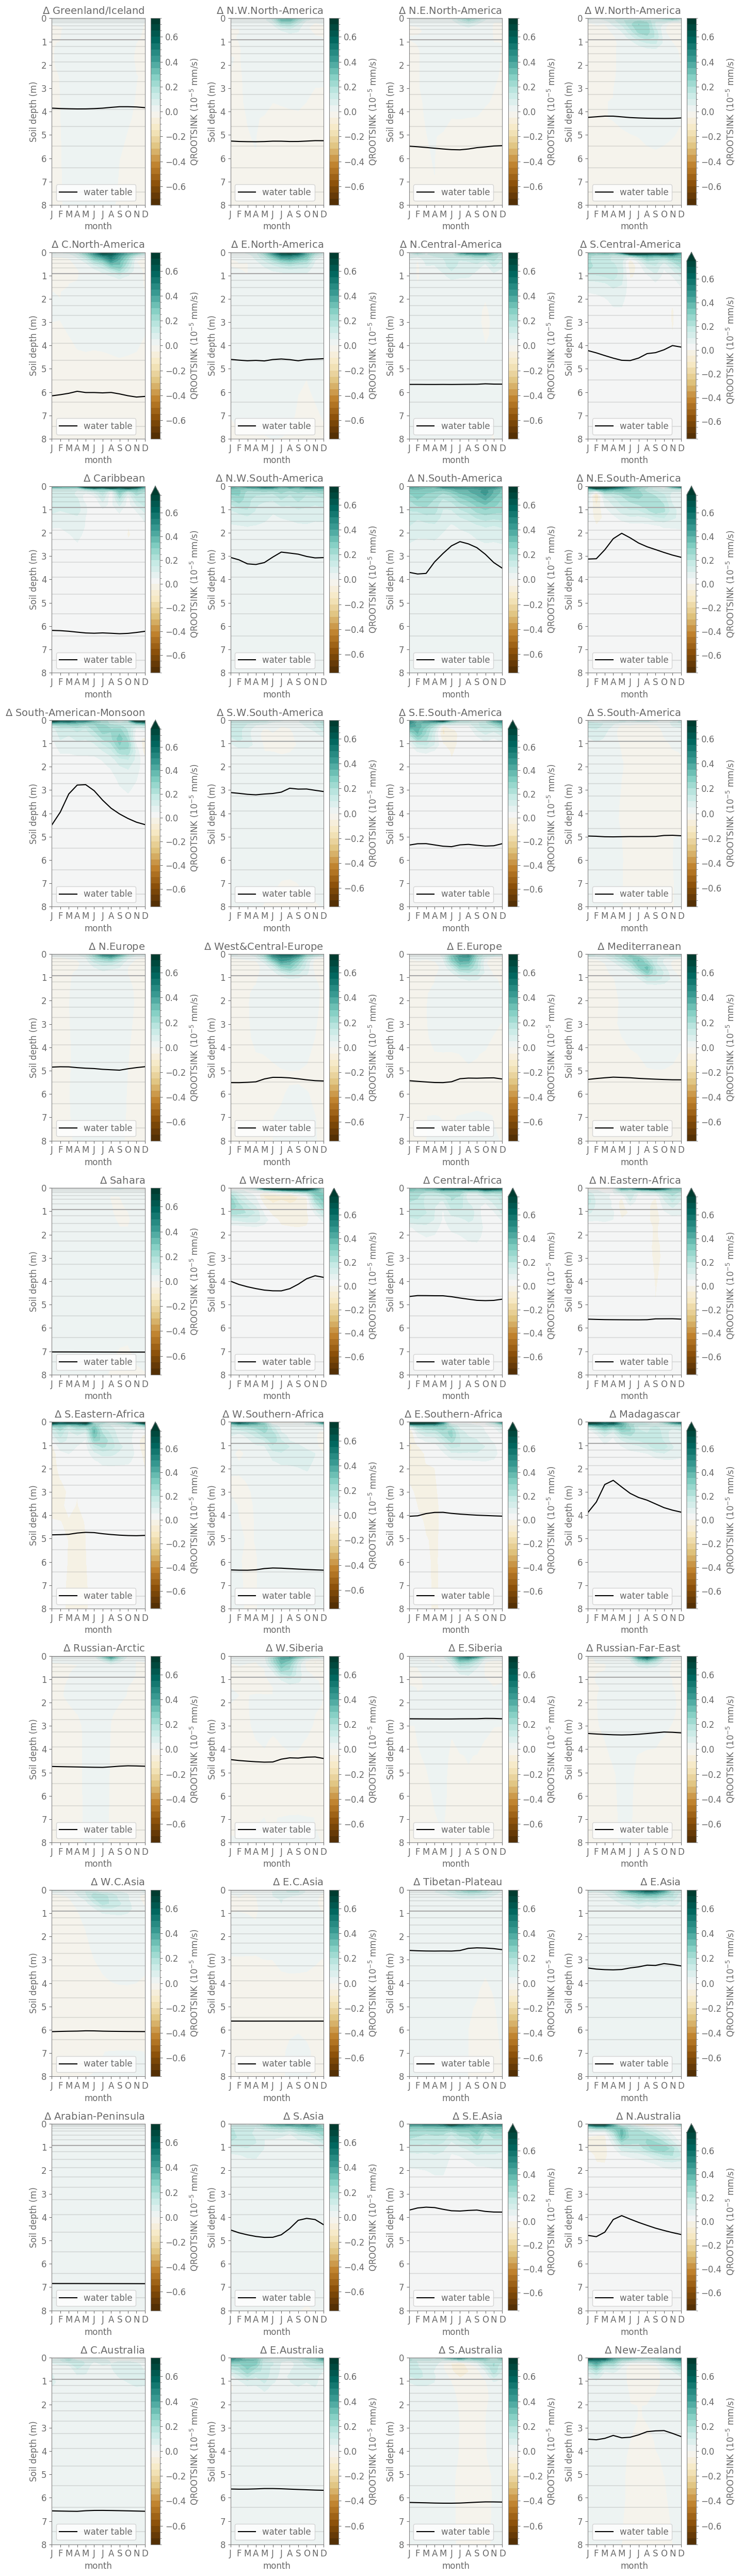

In [22]:
variable= 'QROOTSINK'


mask = regionmask.defined_regions.ar6.land.mask(ds_ctl_seasmean[variable])

region_ids = np.arange(0,44)
fig, axes = plt.subplots(11,4,figsize=(14,50))
axes = axes.flatten()


for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev


    da_ctl_seasmean_region = ds_ctl_seasmean[variable].where(mask==region).mean(dim=('lat','lon'))*10**(5)
    da_ctl_seasmean_region_zwt = ds_ctl_seasmean['ZWT'].where(mask==region).mean(dim=('lat','lon'))

    levels = np.arange(-0.75,0.8,0.05)
    levels_ticks = [0,0.05,0.1,0.2,0.3,0.4,0.5, 0.6]

    ticks = levels_ticks
    
    
    da_ctl_seasmean_region.plot.contourf(ax=ax, x='month', y='levsoi', cmap='BrBG', cbar_kwargs={'label': da_ctl_seasmean_region.name+' (10$^{-5}$ mm/s)'}, levels=levels)
    ax.set_title(region_name, loc='right')
    ax.set_ylim([8,0])
    #da_ctl_seasmean_region_4p1000.plot(ax=ax, label='4p100', color='k')

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

    da_ctl_seasmean_region_zwt.plot(ax=ax, label='water table', color='k')
    ax.legend(loc='lower left') 
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()